In [18]:
# Imports nécessaires

%matplotlib inline

# Suppression de l'affichage des messages d'avertissement
import warnings
warnings.filterwarnings('ignore')


from transformers import AutoTokenizer, DataCollatorWithPadding, AutoModelForSequenceClassification, TrainingArguments, Trainer
from datasets import Features, Value, ClassLabel, Dataset, DatasetDict
from transformers import DistilBertForSequenceClassification, DistilBertTokenizer, Trainer, TrainingArguments
from datasets import load_dataset
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import train_test_split
import torch

# Projet TAL - Transformers

Dans ce notebook ...

## 1. Importation des données

In [ ]:
# Load the dataset
dataset = load_dataset('csv', data_files={'train': 'data/allocine_genres_train.csv', 'test': 'data/allocine_genres_test.csv'}
                       , features=Features({'synopsis': Value(dtype='string'),
                                            'titre': Value(dtype='string'),
                                            'genre': Value(dtype='string')}))

# Combine 'synopsis' and 'titre' into a single 'text' column
def combine_text(data):
    return {'text': data['titre'] + ' ' + data['synopsis']}
dataset = dataset.map(combine_text)

# Convert labels to numbers
labels = ['drame', 'comédie', 'romance', 'policier', 'horreur', 'science fiction', 'biopic', 'documentaire', 'historique']
num_labels = len(labels)
def encode_labels(data):
    data['label'] = labels.index(data['genre'])
    return data
dataset = dataset.map(encode_labels)

# Delete 'synopsis', 'titre' and 'genre' columns
dataset = dataset.remove_columns(['synopsis', 'titre', 'genre'])

# Specify the label column
dataset.set_format('torch', columns=['text', 'label'])

On a maintenant un dataset propre avec les input et les outputs.

In [12]:
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 2875
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 719
    })
})

## 2. Tokenization

On utilise le tokeniser du modèle pré-entrainé pour transformer le texte en tokens.

In [ ]:
# Tokenize the text
tokenizer = AutoTokenizer.from_pretrained('xlm-roberta-base')
def tokenize(batch):
    return tokenizer(batch['text'], padding=True, truncation=True)
dataset = dataset.map(tokenize, batched=True, batch_size=len(dataset))

## 3. Fine-tune the model

In [14]:
#model = AutoModelForSequenceClassification.from_pretrained('xlm-roberta-base', num_labels=num_labels)
# Ou, charger le modèle pré-entrainé
model = AutoModelForSequenceClassification.from_pretrained('models/allocine_xlm-roberta-base')

On définie les hyperparamètres et on initialise les objets de la classe `Trainer` pour l'entraînement et l'évaluation du modèle.

In [15]:
training_args = TrainingArguments(
    output_dir='./results',
    evaluation_strategy='epoch',
    save_strategy='epoch',
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=6, # this can be changed
    weight_decay=0.01,
    push_to_hub=False,
    logging_dir='./logs',
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model='accuracy',
    greater_is_better=True,
    disable_tqdm=False,
    report_to='none'
)

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc}

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset['train'],
    eval_dataset=dataset['test'],
    data_collator=DataCollatorWithPadding(tokenizer=tokenizer),
    compute_metrics=compute_metrics
)

In [10]:
#trainer.train()

You're using a XLMRobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Accuracy
1,1.689600,1.683547,0.431154
2,1.133900,1.441334,0.521558
3,0.916400,1.308381,0.585535
4,0.781900,1.337493,0.567455
5,0.640600,1.398378,0.598053
6,0.519100,1.403406,0.609179


TrainOutput(global_step=2160, training_loss=0.97793901319857, metrics={'train_runtime': 1318.2389, 'train_samples_per_second': 13.086, 'train_steps_per_second': 1.639, 'total_flos': 2584493683629660.0, 'train_loss': 0.97793901319857, 'epoch': 6.0})

In [ ]:
# Exxport the model
#trainer.save_model('allocine_xlm-roberta-base')

The model is now fine-tuned on the dataset. The performances seem to be good.

## 4. Test the model

F1 score:  0.5894939679131366


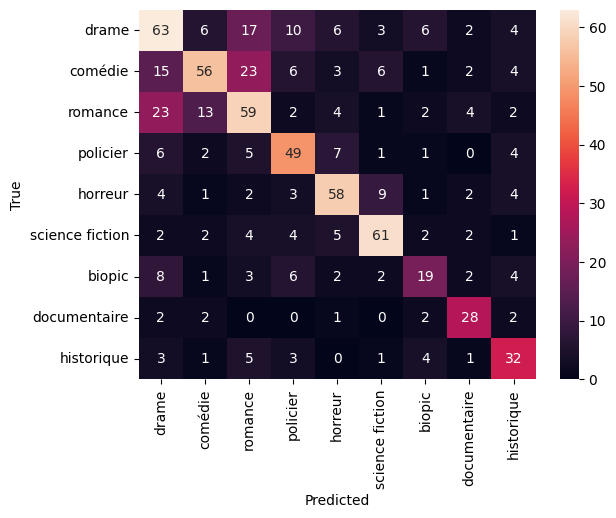

In [20]:
# Evaluate the model with f1 score
trainer.evaluate()

# Predict
preds = trainer.predict(dataset['test'])
pred_labels = preds.predictions.argmax(-1)
true_labels = dataset['test']['label']

print('F1 score: ', f1_score(true_labels, pred_labels, average='weighted'))

# Confusion matrix
from sklearn.metrics import confusion_matrix

preds = trainer.predict(dataset['test'])
pred_labels = preds.predictions.argmax(-1)
true_labels = dataset['test']['label']

conf_mat = confusion_matrix(true_labels, pred_labels)
sns.heatmap(conf_mat, annot=True, fmt='d', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [21]:
# Predict the labels on the test set and add them to the dataset
preds = trainer.predict(dataset['test'])
pred_labels = preds.predictions.argmax(-1)
dataset['test'] = dataset['test'].add_column('pred_label', pred_labels)

In [25]:
# Load the 'pred_labels' into a csv file
test_df = dataset['test'].to_pandas()
test_df = test_df.drop(columns=['text', 'label', 'attention_mask','input_ids'])
test_df.to_csv('data/allocine_genres_test_pred.csv', index=False)